In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import tensorflow_io as tfio
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten


2023-11-13 11:11:02.602341: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 11:11:02.620429: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 11:11:02.747776: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 11:11:02.748701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 11:11:03.643419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# 1. Dataloading Function
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

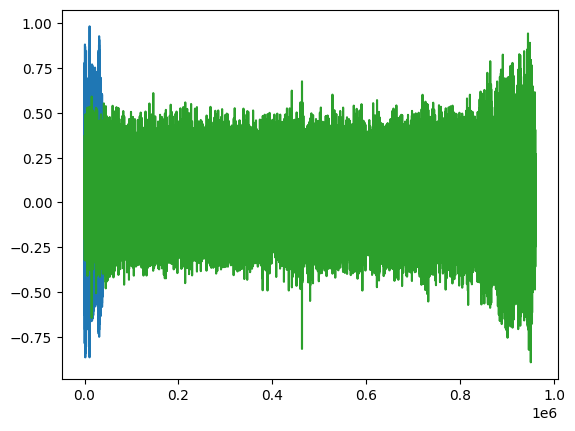

In [4]:
# 2. Plotting the wav file
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')
COW_FILE='file.wav'
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
cwave = load_wav_16k_mono(COW_FILE)
plt.plot(wave)
plt.plot(nwave)
plt.plot(cwave)
plt.show()

In [7]:
# 3. Creating Tensorflow Datasets

POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')
pos = tf.data.Dataset.list_files(POS+'/*.wav') # slash modifiers differs between OS
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

# Add labels and Combine Positive and Negative Samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [8]:
# 4. Understanding the dataset

#Calculating the wave cycle length
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

# Mean, Min and Max of the wave cycle length
print(f"Mean : {tf.math.reduce_mean(lengths)}")
print(f"Min : {tf.math.reduce_min(lengths)}")
print(f"Max : {tf.math.reduce_max(lengths)}")

Mean : 54156
Min : 32000
Max : 80000


In [9]:
#  5. Building the preprocessing function
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

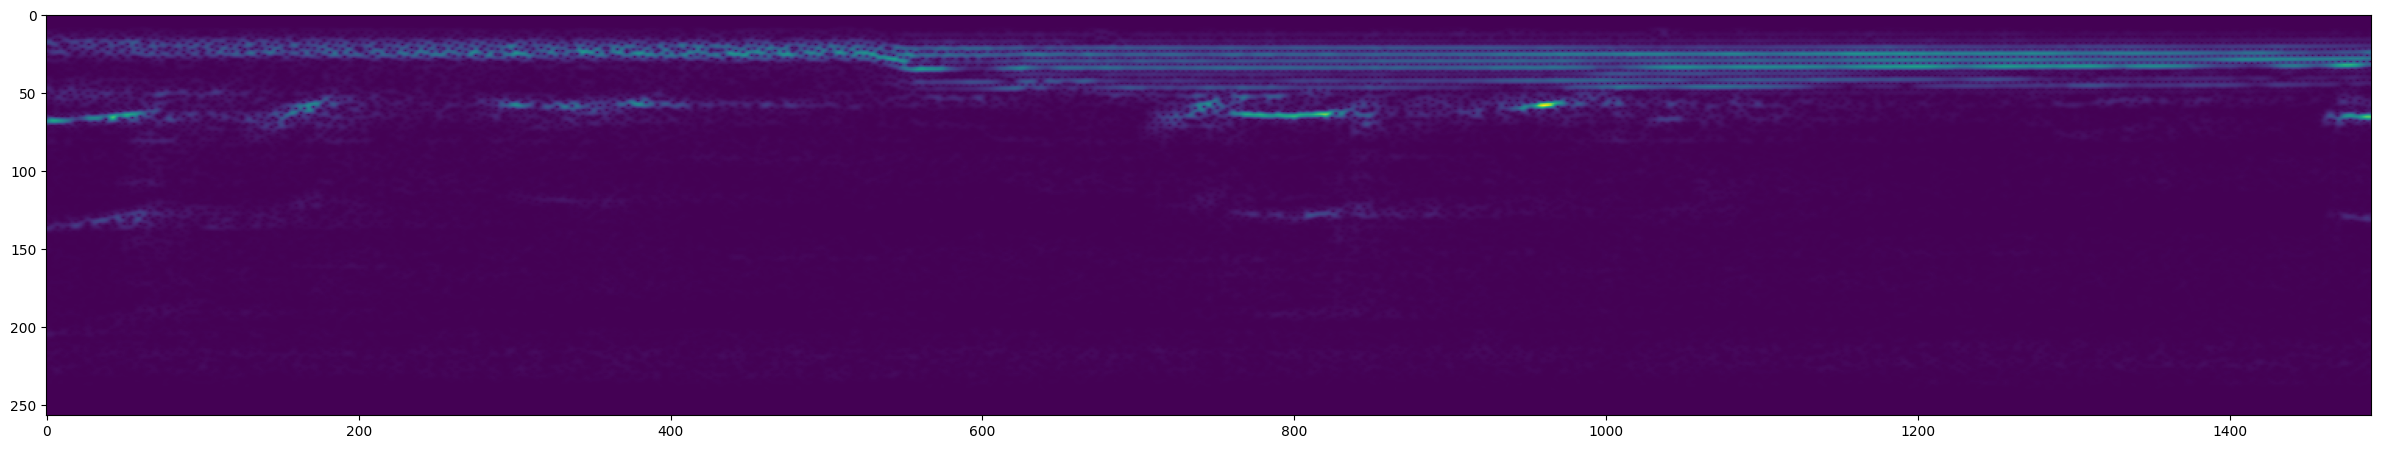

In [10]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
# 6.Creating training and testing partitions
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

# Splitting the data into training and testing partitions
train = data.take(36)
test = data.skip(36).take(15)


In [ ]:
# Testing Single batch 
samples, labels = train.as_numpy_iterator().next()
samples.shape

In [ ]:
# 7. Building the model
#TODO:
# 1. Replace it with YAMNet model
# 2. Finetune dense layer at the end for simple model

print(tf.version.VERSION)


model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))




In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [ ]:
model.summary()

In [ ]:
# 8. Fit and evaluate the model
hist = model.fit(train, epochs=2, validation_data=test)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plotting Loss
axes[0].plot(hist.history['loss'], 'r', label='Training Loss')
axes[0].plot(hist.history['val_loss'], 'b', label='Validation Loss')
axes[0].set_title('Loss')
axes[0].legend()

# Plotting Precision
axes[1].plot(hist.history['precision'], 'r', label='Training Precision')
axes[1].plot(hist.history['val_precision'], 'b', label='Validation Precision')
axes[1].set_title('Precision')
axes[1].legend()

# Plotting Recall
axes[2].plot(hist.history['recall'], 'r', label='Training Recall')
axes[2].plot(hist.history['val_recall'], 'b', label='Validation Recall')
axes[2].set_title('Recall')
axes[2].legend()

# Adjusting the layout
plt.tight_layout()
plt.show()

In [ ]:
# 8. Making Predictions

# On a single batch
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)

# Convert Logits to Classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
# 9. Building parser functions:

def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')
wav = load_mp3_16k_mono(mp3)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
# 10. Convert clips into spectrograms:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
# 11. Convert Longer Clips into Windows and Make Predictions
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
## 12. Group Consecutive Detections
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
calls

In [ ]:
# 13. Loop over the recordings:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat
results


In [ ]:
## 13. Convert Predictions into Classes
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

# 14. Group Consecutive Detections
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

In [ ]:
# 14. Export the result
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])